In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import math

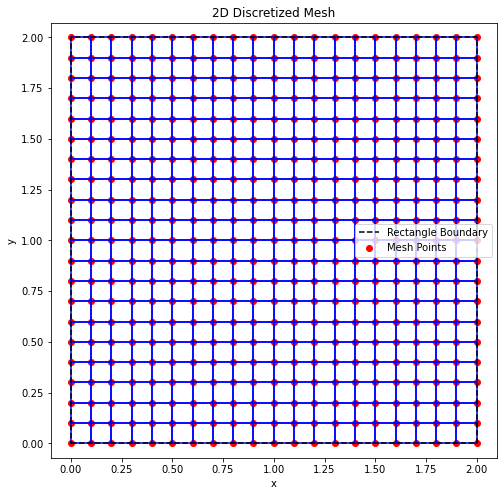

In [34]:
def MakeDiscreteCells(l, w, maxEdgeLength=0.1):
    """
    l, w [float]: dimensions of 2D rectangular body
    
    maxEdgeLength [float]: max length of edge of any cell
    
    returns: array of tuples (2D points) and rectangular cells, indexed into points array.
    """
    assert(l>0)
    assert(w>0)
    
    points2d = []
    cells = []
    
    numRows = math.ceil(l / maxEdgeLength)
    numCols = math.ceil(w / maxEdgeLength)
    lDist = l / numRows
    wDist = w / numCols
    
    rowp2ds = [0]
    colp2ds = [0]
    n = 1
    k = 1
    
    for _ in range(numRows-1):
        rowp2ds.append(n*lDist)
        n += 1
    for _ in range(numCols-1):
        colp2ds.append(k*wDist)
        k += 1
    
    rowp2ds.append(l)
    colp2ds.append(w)
    
    # Generate 2D Points
    for rp in rowp2ds:
        for cp in colp2ds:
            points2d.append((cp, rp))
    
    # Generate Indexed Cells
    for i in range(len(points2d)-(len(colp2ds)+1)):
        if (i>0) and ((i+1)%len(colp2ds)==0):
            continue
    
        cell = [i, i+1, i+len(colp2ds)+1, i+len(colp2ds)]
        cells.append(cell)
    
    return points2d, cells

def VizMesh2D(points2d, cells):
    """
    Given 2D Point and Quad/Rectangle cell information, visualizes the discretized 2D body.
    """
    xCoords, yCoords = zip(*points2d)
    
    # Dynamic aspect ratio
    maxW = max(xCoords) - min(xCoords)
    maxL = max(yCoords) - min(yCoords)
    aspectRatio = maxW / maxL
    base = 8
    width = base * aspectRatio if aspectRatio >= 1 else base
    length = base / aspectRatio if aspectRatio < 1 else base
    
    # Create the plot
    plt.figure(figsize=(width, length))
    plt.scatter(xCoords, yCoords, color='red', label='Mesh Points')  # Scatter plot of points
    
    # Draw the cells
    for cell in cells:
        # Get the corner points of the cell
        cellPoints = [points2d[cell[i]] for i in range(4)] + [points2d[cell[0]]]  # Close the rectangle
        cellX, cellY = zip(*cellPoints)
        plt.plot(cellX, cellY, color='blue')  # Plot cell edges
    
    # Draw the boundary of the rectangle
    rectX = [0, max(xCoords), max(xCoords), 0, 0]
    rectY = [0, 0, max(yCoords), max(yCoords), 0]
    plt.plot(rectX, rectY, color='black', linestyle='--', label='Rectangle Boundary')
    
    # Labels
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Discretized Mesh')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Example
points, cells = MakeDiscreteCells(2, 2, 0.1)
VizMesh2D(points, cells)


In [62]:
materials = {
    "aluminum": 0.1,
    "copper": 0.12,
    "steel": 0.05,
}

def SimulateHeatDiffusion(V, C, heatSourceIndex, temp, material, numSteps=100, snapshotTimes=[10, 50, 100], dt=0.1):
    """
    Simulates heat diffusion on a 2D rectangular mesh.
    
    V [List[Tuple[float, float]]]: List of 2D vertices (points)
    C [List[List[int, int, int, int]]]: List of rectangular cells (indices into V)
    heatSourceIndex [int]: Index of the cell where heat is applied
    temp [float]: Initial temperature of the heat source
    material [str]: String representing material type (maps to thermal diffusivity constant)
    numSteps [int]: Total simulation time steps
    snapshotTimes [List[int]]: List of time steps at which snapshots are taken
    dt [float]: Time step size
    
    Returns:
        snapshots [List[List[float]]]: List of temperature arrays for the specified snapshots
    """
    
    # Thermal diffusivity
    alpha = materials.get(material, 0.1)  # Default if material not found

    # Initialize temperature array
    temperatures = np.zeros(len(V))  # Temperature at each vertex
    snapshots = []

    # Set initial temperature at the heat source
    for vertex_idx in C[heatSourceIndex]:
        temperatures[vertex_idx] = temp

    # Simulate heat transfer
    for step in range(1, numSteps + 1):
        new_temperatures = temperatures.copy()

        for cell in C:
            for vertex_idx in cell:
                # Identify neighbors of this vertex
                neighbors = [v for v in cell if v != vertex_idx]
                # Heat diffusion calculation (simplified)
                new_temperatures[vertex_idx] += alpha * dt * sum(
                    temperatures[neighbor] - temperatures[vertex_idx] for neighbor in neighbors
                )
        
        temperatures = new_temperatures

        # Store snapshots at specified time steps
        if step in snapshotTimes:
            snapshots.append(temperatures.copy())

    return snapshots

def VizHeatSnapshots(V, C, snapshots, snapshotTimes):
    fig, axes = plt.subplots(1, len(snapshots), figsize=(15, 5))

    for i, (temps, time) in enumerate(zip(snapshots, snapshotTimes)):
        ax = axes[i]
        for cell in C:
            # Average temperature of the cell
            cell_temp = np.mean([temps[v_idx] for v_idx in cell])
            cell_points = [V[v_idx] for v_idx in cell]
            polygon = plt.Polygon(cell_points, closed=True, color=plt.cm.hot(cell_temp / max(temps)))
            ax.add_patch(polygon)

        ax.set_title(f'Time = {time * dt}')
        ax.set_xlim(0, max(v[0] for v in V))
        ax.set_ylim(0, max(v[1] for v in V))
        ax.set_aspect('equal')
    plt.colorbar(plt.cm.ScalarMappable(cmap='hot'), ax=axes, orientation='horizontal', label='Temperature')
    plt.show()


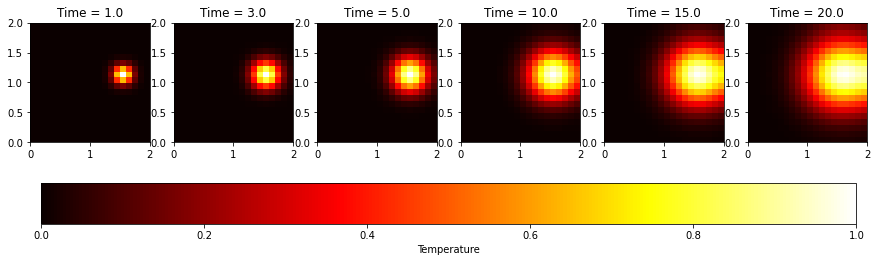

In [63]:
# Create mesh
V, C = MakeDiscreteCells(2, 2, 0.1)

# Simulate heat diffusion
snapshots = SimulateHeatDiffusion(
    V, C, heatSourceIndex=(int(len(C)/1.7)), temp=270, material="aluminum",
    numSteps=200, snapshotTimes=[10, 30, 50, 100, 150, 200]
)

# Visualize snapshots
VizHeatSnapshots(V, C, snapshots, snapshotTimes=[10, 30, 50, 100, 150, 200])